# Cargamos los datos, separamos en train, validation y test. Y Añadimos el ruido con ayuda de una ia de generacion

**Prompt: "Generate code to add Gaussian noise of snr 3db to the fashion mnist database, and also add salt and pepper noise 
In the end my data would consist on the clean fashion mnist db, the gaussian contamined fashion mnist db, and the salt and pepper contamined fashion mnist db"**

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


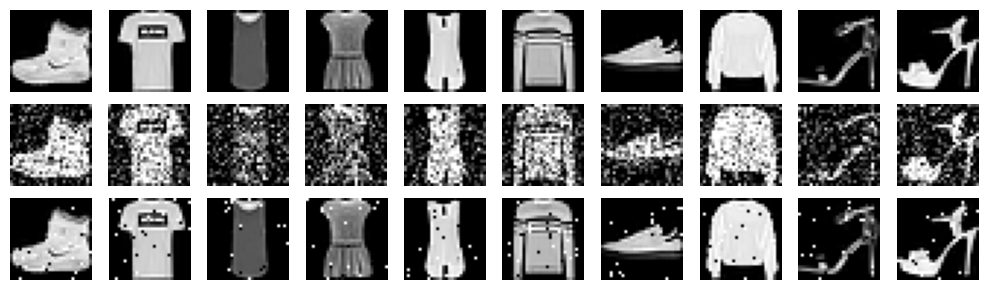

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load Fashion MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize images to [0,1] range
x_train_full = x_train.astype(np.float32) / 255.0
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
x_test = x_test.astype(np.float32) / 255.0
y_train, y_valid = y_train[:-5000], y_train[-5000:]

# Function to add Gaussian noise with a given SNR in dB
def add_gaussian_noise(images, snr_db):
    signal_power = np.mean(images ** 2)
    snr_linear = 10 ** (snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise_std = np.sqrt(noise_power)
    
    noise = np.random.normal(0, noise_std, images.shape)
    noisy_images = images + noise
    return np.clip(noisy_images, 0, 1)  # Ensure values remain in [0,1]

# Function to add Salt & Pepper noise
def add_salt_and_pepper_noise(images, salt_prob=0.02, pepper_prob=0.02):
    noisy_images = np.copy(images)
    total_pixels = images.shape[1] * images.shape[2]

    # Salt noise (white pixels)
    for img in noisy_images:
        num_salt = int(salt_prob * total_pixels)
        coords = [np.random.randint(0, i, num_salt) for i in img.shape]
        img[coords[0], coords[1]] = 1.0

    # Pepper noise (black pixels)
    for img in noisy_images:
        num_pepper = int(pepper_prob * total_pixels)
        coords = [np.random.randint(0, i, num_pepper) for i in img.shape]
        img[coords[0], coords[1]] = 0.0

    return noisy_images

# Generate noisy datasets
x_train_gaussian = add_gaussian_noise(x_train, snr_db=3)
x_valid_gaussian = add_gaussian_noise(x_valid, snr_db=3)
x_test_gaussian = add_gaussian_noise(x_test, snr_db=3)

x_train_saltpepper = add_salt_and_pepper_noise(x_train)
x_valid_saltpepper = add_salt_and_pepper_noise(x_valid)
x_test_saltpepper = add_salt_and_pepper_noise(x_test)


# Display sample images
fig, axs = plt.subplots(3, 10, figsize=(10, 3))

for i in range(10):
    axs[0, i].imshow(x_train[i], cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].imshow(x_train_gaussian[i], cmap="gray")
    axs[1, i].axis("off")
    axs[2, i].imshow(x_train_saltpepper[i], cmap="gray")
    axs[2, i].axis("off")

axs[0, 0].set_ylabel("Clean", fontsize=12)
axs[1, 0].set_ylabel("Gaussian", fontsize=12)
axs[2, 0].set_ylabel("Salt & Pepper", fontsize=12)

plt.tight_layout()
plt.show()

# Creamos el conjunto de etiquetas basadas en genero (Hombre, Mujer, Unisex)
**Prompt: I also need 2 outputs, the normal classification of the 10 classes in fashion mnist, and a classification of the clothes in men, women, and unisex clothes.
For that I need another Y array that serves for that classification. Help me with it"**

In [2]:
# Mapping classes to new categories (Men: 0, Women: 1, Unisex: 2)
category_map = {
    0: 2,  # T-shirt/top -> Unisex
    1: 2,  # Trouser -> Unisex
    2: 2,  # Pullover -> Unisex
    3: 1,  # Dress -> Women
    4: 2,  # Coat -> Unisex
    5: 1,  # Sandal -> Women
    6: 0,  # Shirt -> Men
    7: 0,  # Sneaker -> Men
    8: 1,  # Bag -> Women
    9: 1   # Ankle boot -> Women
}

# Apply mapping to training and test labels
y_train_category = np.array([category_map[label] for label in y_train])
y_valid_category = np.array([category_map[label] for label in y_valid])
y_test_category = np.array([category_map[label] for label in y_test])


# Print sample counts per category
unique, counts = np.unique(y_train_category, return_counts=True)
print("Training set category distribution:", dict(zip(unique, counts)))
unique, counts = np.unique(y_valid_category, return_counts=True)
print("Validation set category distribution:", dict(zip(unique, counts)))
unique, counts = np.unique(y_test_category, return_counts=True)
print("Test set category distribution:", dict(zip(unique, counts)))

Training set category distribution: {0: 11083, 1: 21952, 2: 21965}
Validation set category distribution: {0: 917, 1: 2048, 2: 2035}
Test set category distribution: {0: 2000, 1: 4000, 2: 4000}


# Definición del la arquitectura

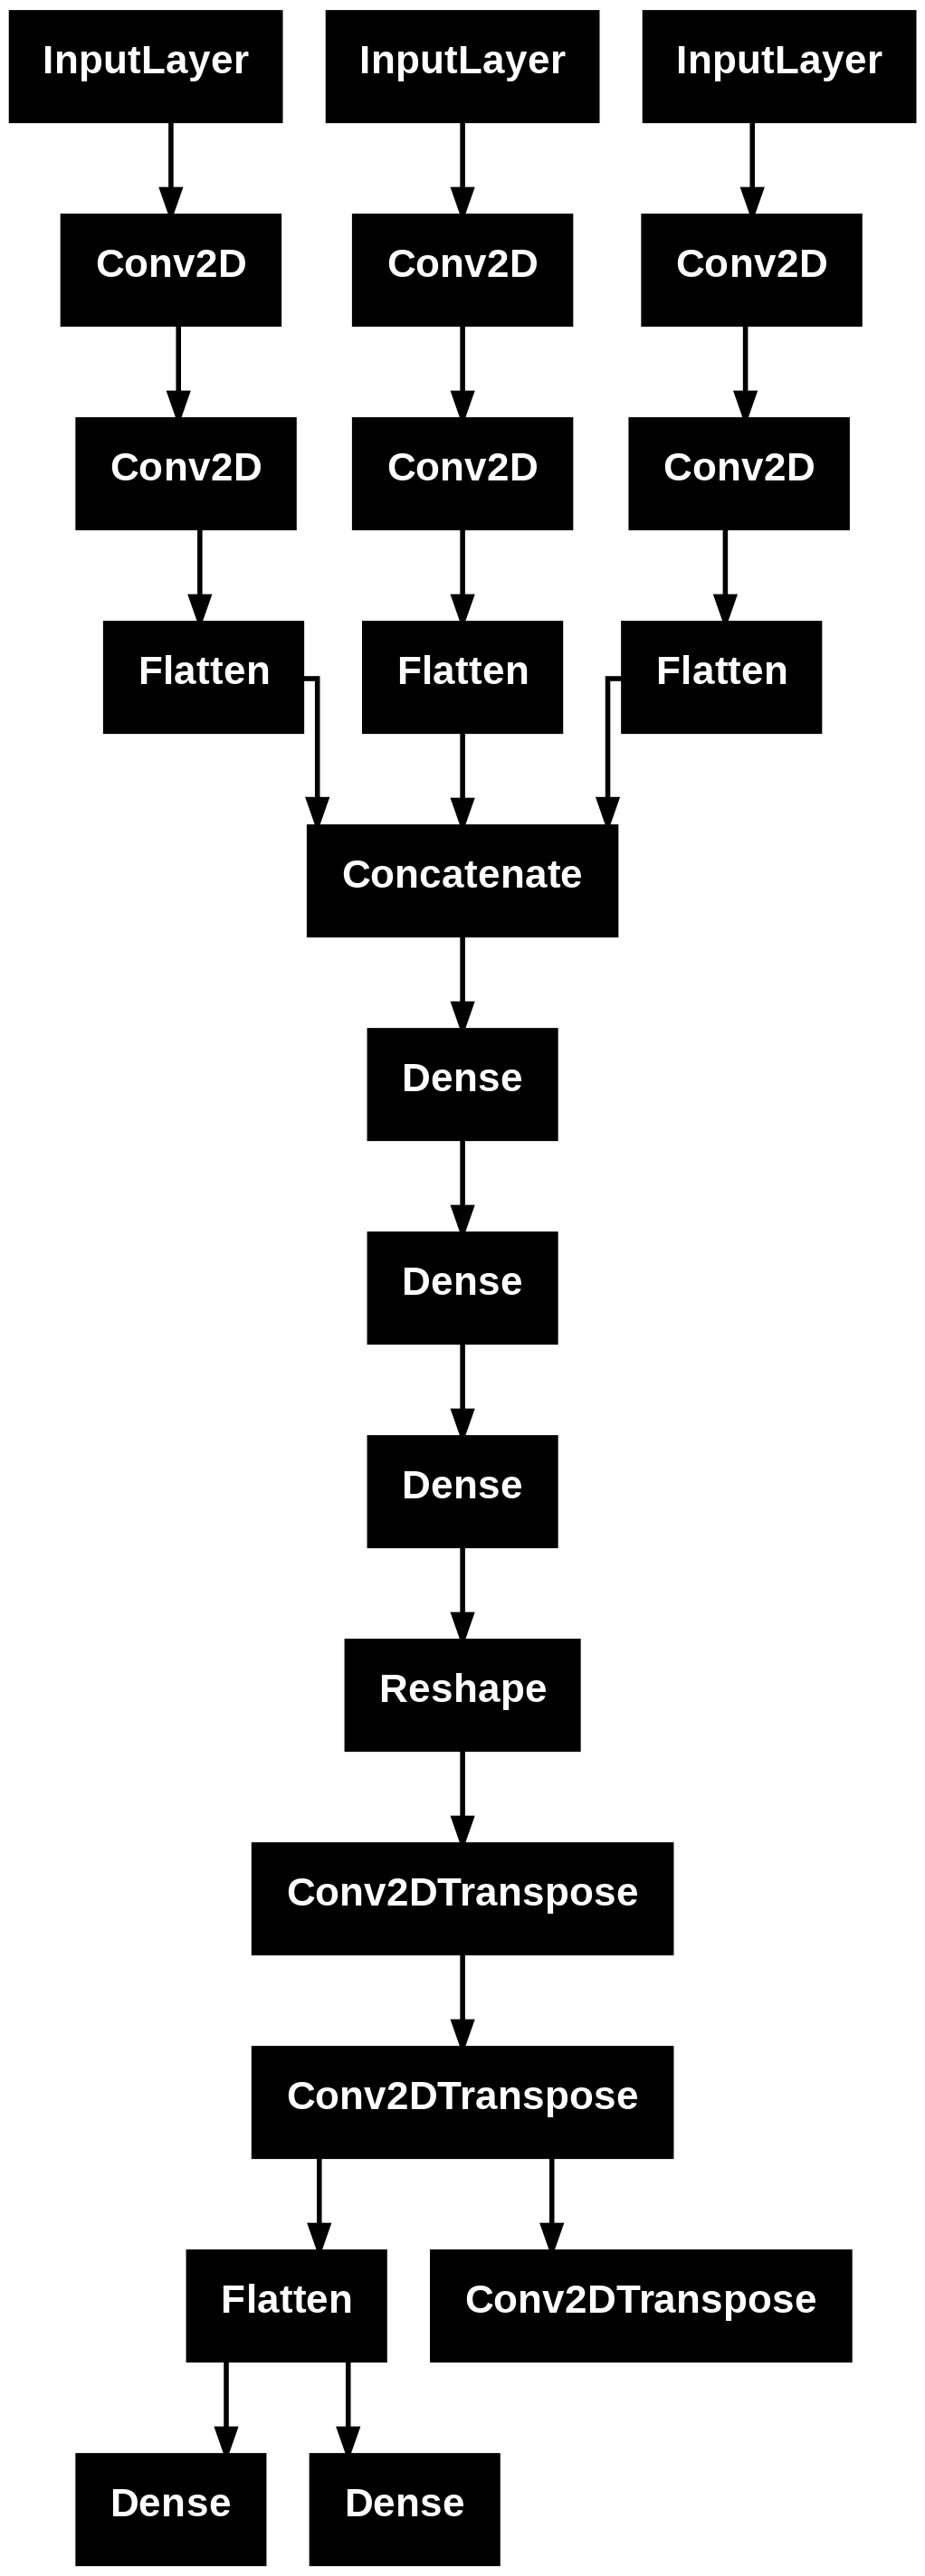

In [34]:
#Seed para evitar el factor aleatorio
tf.random.set_seed(42)
np.random.seed(42)
#definimos el tamaño del batch
batch=64
#Definimos una funcion para crear el encoder con la API funcional
def build_autoencoder(latent_dim):
    Inputs_1 = tf.keras.layers.Input(shape=(28, 28, 1))
    Inputs_2 = tf.keras.layers.Input(shape=(28, 28, 1))
    Inputs_3 = tf.keras.layers.Input(shape=(28, 28, 1))
    h1_0 = tf.keras.layers.Conv2D(32, 3, activation='selu', strides=2, padding='same')(Inputs_1)
    h2_0 = tf.keras.layers.Conv2D(32, 3, activation='selu', strides=2, padding='same')(Inputs_2)
    h3_0 = tf.keras.layers.Conv2D(32, 3, activation='selu', strides=2, padding='same')(Inputs_3)
    
    h1_1 = tf.keras.layers.Conv2D(64, 3, activation='selu', strides=2, padding='same')(h1_0)
    h2_1 = tf.keras.layers.Conv2D(64, 3, activation='selu', strides=2, padding='same')(h2_0)
    h3_1 = tf.keras.layers.Conv2D(64, 3, activation='selu', strides=2, padding='same')(h3_0)
    f1 = tf.keras.layers.Flatten()(h1_1)
    f2 = tf.keras.layers.Flatten()(h2_1)
    f3 = tf.keras.layers.Flatten()(h3_1)
    #x = keras.layers.BatchNormalization()(x)
    conc = tf.keras.layers.Concatenate()([f1,f2,f3])
    h_2 = tf.keras.layers.Dense(128, activation='selu')(conc)
    h_3 = tf.keras.layers.Dense(latent_dim, activation='selu',name='latent_space')(h_2)
    #x = keras.layers.Dropout(0.5)(x)
    h_4 = tf.keras.layers.Dense(7*7*64, activation='selu', name='Decoder_input')(h_3)
    reshape = tf.keras.layers.Reshape((7, 7, 64))(h_4)
    h_5 = tf.keras.layers.Conv2DTranspose(64, 3, activation='selu', strides=2, padding='same')(reshape)
    h_6 = tf.keras.layers.Conv2DTranspose(32, 3, activation='selu', strides=2, padding='same')(h_5)
    out_1 = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same',name='output_reconstruccion')(h_6)
    f4 = tf.keras.layers.Flatten()(h_6)
    out_2 = tf.keras.layers.Dense(10,activation="softmax",name='output_class_10')(f4)
    out_3 = tf.keras.layers.Dense(3,activation="softmax",name='output_class_3')(f4)
    autoencoder = tf.keras.Model([Inputs_1,Inputs_2,Inputs_3], [out_1, out_2,out_3], name='Autoencoder')
    return autoencoder

latent_dim=10
model= build_autoencoder(latent_dim)
tf.keras.utils.plot_model(model)
#model.summary()

In [35]:
#Clear session para no guardar datos de entrenamientos anteriores
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=["mse","sparse_categorical_crossentropy","sparse_categorical_crossentropy"],metrics=["accuracy","accuracy","accuracy"])
tf.keras.backend.clear_session()
history=model.fit([x_train,x_train_gaussian,x_train_saltpepper], [x_train,y_train,y_train_category], epochs=10, batch_size=batch, validation_data=([x_valid,x_valid_gaussian,x_valid_saltpepper], [x_valid,y_valid,y_valid_category]))#,callbacks=[scheduler])

Epoch 1/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 19.3669 - output_class_10_accuracy: 0.1001 - output_class_10_loss: 12.3908 - output_class_3_accuracy: 0.3824 - output_class_3_loss: 6.8540 - output_reconstruccion_accuracy: 0.4832 - output_reconstruccion_loss: 0.1221 - val_loss: 3.4590 - val_output_class_10_accuracy: 0.0934 - val_output_class_10_loss: 2.3162 - val_output_class_3_accuracy: 0.4070 - val_output_class_3_loss: 1.0502 - val_output_reconstruccion_accuracy: 0.4820 - val_output_reconstruccion_loss: 0.0927
Epoch 2/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.4792 - output_class_10_accuracy: 0.0990 - output_class_10_loss: 2.3224 - output_class_3_accuracy: 0.3988 - output_class_3_loss: 1.0635 - output_reconstruccion_accuracy: 0.4875 - output_reconstruccion_loss: 0.0933 - val_loss: 3.4580 - val_output_class_10_accuracy: 0.0934 - val_output_class_10_loss: 2.3187 - val_output_class_3_accuracy: 0.4096 - val_output_class_3_loss: 1.0421 - val_output_reconstruccion_ac

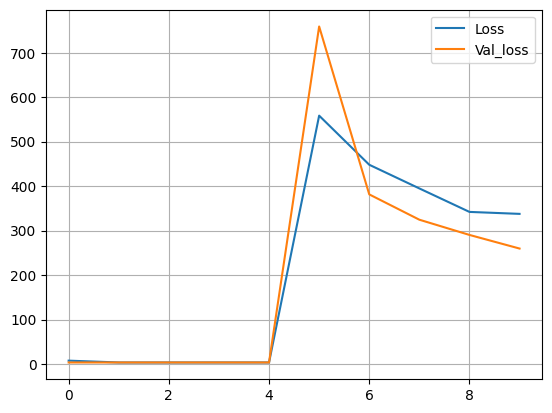

In [36]:
#Graficamos el loss de entrenamiento y validación
plt.plot(history.history["loss"],label="Loss")
plt.plot(history.history["val_loss"],label="Val_loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0.49,0.52)
plt.legend()
plt.show()